In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import sys
import random
sys.path.append('../src/')
from random_graph import RandGraph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

## Model

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Input is a vector of nodes' congestion  in the current state. Output is the action vector.

In [47]:
state_size = 10
action_size = 10

In [59]:
model = Sequential()
model.add(Dense(32, input_dim=state_size, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(action_size, activation='softmax'))

In [60]:
model.compile(loss='mse', optimizer='adam')

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                330       
Total params: 1,738
Trainable params: 1,738
Non-trainable params: 0
_________________________________________________________________


## Network

In [7]:
g = RandGraph(actors=100, moving=5, n_core_nodes=10)

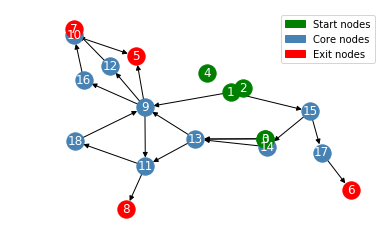

In [8]:
g.plot()

In [44]:
state, reward = g.action()

In [45]:
# nodes congestion
state

array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [46]:
reward

20.0

## Action vector

In [66]:
model.predict(state) > 0.1

array([[ True,  True,  True,  True, False, False,  True, False,  True,
        False]])

In [70]:
action_vector = model.predict(state) > 0.1

In [74]:
next_act = np.where(action_vector==True)[1] + min(g.core_nodes)

In [77]:
list(next_act)

[9, 10, 11, 12, 15, 17]

In [179]:
epsilon = 0.5
def act(state):
    if np.random.rand() <= epsilon:
        # random action
#         print('random')
        k = random.randrange(0,len(g.core_nodes))
        return random.sample(g.core_nodes, k)
    else:
        # predicted action
#         print('predicted')
        action_vector = model.predict(state) > 0.5
        next_act = np.where(action_vector == True)[1] + min(g.core_nodes)
        return list(next_act)

In [188]:
act(state)

random


[10, 16, 18, 15, 17]

## get next state and reward

In [78]:
next_state, reward = g.action(list(next_act))

In [79]:
next_state

array([[0.25, 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [80]:
reward

-6.666666666666666

## Deep Q-learning with experience replay

Initialize replay memory $ \mathcal D $ to capacity $\mathrm N $
Initialize action-value function $\mathcal Q$ with random weights

$\quad$ **for** $episode = 1, M $ **do**   
$\quad$ Initialize sequence $ s_1 = \{x_1\}$ and preprocessed sequenced $ \phi_1 = \phi(s_1)$  
$\quad$ $\quad$ **for** $ t = 1, T $ **do**  
$\quad$ $\quad$ $\quad$ With probability $\epsilon$ to select a random action $ a_t $ or predicted action $ a_t = max_a Q^*(\phi(s_t),a; \theta) $  
$\quad$ $\quad$ $\quad$ Execute action $a_t$ and observe reward $r_t$ and state $x_{t+1}$  
$\quad$ $\quad$ $\quad$ Set $s_{t+1} = s_t, a_t, x_{t+1}$  and preprocess $\phi_{t+1} = \phi(s_{t+1})$  
$\quad$ $\quad$ $\quad$ Store transition $(\phi_t, a_t, r_t, \phi_{t+1}) \,\, in \,\, \mathcal D $  
$\quad$ $\quad$ $\quad$ Sample random minibatch transitions $(\phi_j, a_j, r_j, \phi_{j+1}$ from $\mathcal D$  
$\quad$ $\quad$ $\quad$ Set $ y_i = \bigg\{^{r_j}_{r_j + \gamma max_{a'}Q(\phi_{j+1}, a'; \theta)} $ for terminal or non terminal $\phi_{j+1}$, respectively  
$\quad$ $\quad$ $\quad$ Perform gradient descent step on $(y_i - Q(\phi_j, a_j; \theta))^2 $  
$\quad$ $\quad$ **end for**  
$\quad$ **end for**  

$\phi$ is a function producing a fixed length representation of histories.  
$s_t$ is the finite sequence of observation and actions $ x_1, a_1, x_2, \ldots , a_{t-1}, x_t $ at time $t$  
$Q^*(s,a)$ is the maximum expected return achievable by following any strategy after some sequence $s$ and action $a$
$$ Q^*(s,a) = max_\pi \mathbb E \left[R_t \,\rvert\, s_t = s, a_t = a, \pi \right] $$  
where $\pi$ is the policy mapping sequences to actions.  
